# 1. Downloading python scripts to ease the training of the models 


In [ ]:
import torch
import torchvision
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from pathlib import Path
from PIL import Image

torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend 
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

[INFO] Couldn't find torchinfo... installing it.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [ ]:
from drive.MyDrive.gitclone.EndoscopicImagesClassificationDL.Pytorch_Modules import data_setup, helper_functions, train_step

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
dataset_path = Path("/content/drive/My Drive/Dataset")
helper_functions.walk_through_dir(dataset_path)
train_dir = dataset_path / "train"
test_dir = dataset_path / "test"

Found 2 directories and 0 Images in /content/drive/My Drive/Dataset
Found 3 directories and 0 Images in /content/drive/My Drive/Dataset/train
Found 0 directories and 307 Images in /content/drive/My Drive/Dataset/train/Nose
Found 0 directories and 220 Images in /content/drive/My Drive/Dataset/train/Ear
Found 0 directories and 112 Images in /content/drive/My Drive/Dataset/train/VocalFolds
Found 3 directories and 0 Images in /content/drive/My Drive/Dataset/test
Found 0 directories and 128 Images in /content/drive/My Drive/Dataset/test/Nose
Found 0 directories and 37 Images in /content/drive/My Drive/Dataset/test/Ear
Found 0 directories and 78 Images in /content/drive/My Drive/Dataset/test/VocalFolds


# 2. create datasets and dataloaders

to use `torchvision.models` the image has to be loaded in to a range of [0,1] and the normalized using  mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

* genarally you should take a look on the docu and check the requierd shape, pixel values, mean and standard daviation and include them while transforming

In [ ]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # this includes scaling the pixel values 0..1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

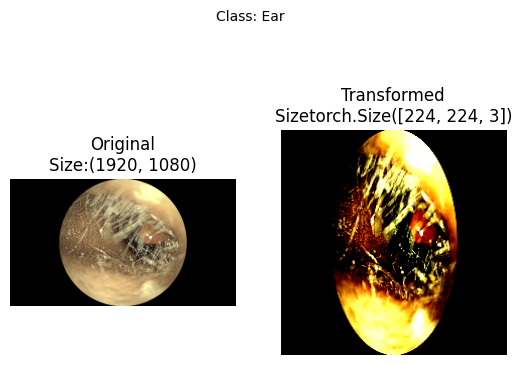

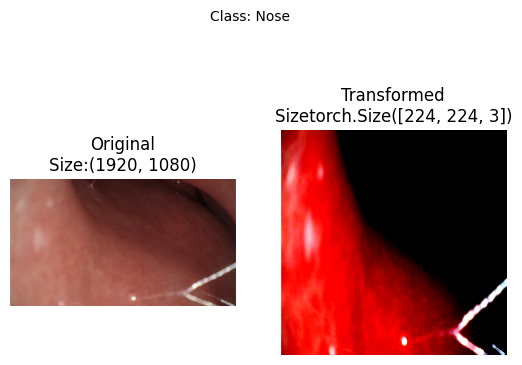

In [ ]:
image_path_list = list(dataset_path.glob("*/*/*.png"))
helper_functions.plot_transformed_images(image_path_list, manual_transforms, 2)

## 2.2 creating autotransforms from `torchvision.model`

In [ ]:
# get the weights of the pretraind model 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms
auto_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


(functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224, resize_size=256, interpolation=<InterpolationMode.BICUBIC: 'bicubic'>),
 EfficientNet_B0_Weights.IMAGENET1K_V1,
 odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.0.block.0.0.weight', 'features.1.0.block.0.1.weight', 'features.1.0.block.0.1.bias', 'features.1.0.block.0.1.running_mean', 'features.1.0.block.0.1.running_var', 'features.1.0.block.0.1.num_batches_tracked', 'features.1.0.block.1.fc1.weight', 'features.1.0.block.1.fc1.bias', 'features.1.0.block.1.fc2.weight', 'features.1.0.block.1.fc2.bias', 'features.1.0.block.2.0.weight', 'features.1.0.block.2.1.weight', 'features.1.0.block.2.1.bias', 'features.1.0.block.2.1.running_mean', 'features.1.0.block.2.1.running_var', 'features.1.0.block.2.1.num_batches_tracked', 'features.2.0.block.0.0.weight', 'features

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=manual_transforms,
                                                                               test_transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

# 3. getting a pretrained model

In [ ]:
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)
model_1

In [ ]:
summary(model=model_1, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

## 3.1 Adjusting the out features of the model to suite my case

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.
for param in model_1.features.parameters():
    param.requires_grad = False

NameError: ignored

In [ ]:
# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_1, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# model_1: train the model

In [ ]:
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
start_time = timer()
results = train_step.train(model=model_1,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           optimizer=optimizer_1,
                           loss_fn=loss_fn_1,
                           epochs=11,
                           device=device)
end_time = timer()
print(f"total training time: {end_time-start_time:.3f} secconds")

In [ ]:
helper_functions.plot_loss_curves(results)

In [ ]:
img, path = helper_functions.get_random_image_from_dir(dataset_path)
helper_functions.predict_on_custom(model=model_1,
                  img_path=path,
                  class_names=class_names,
                  target_size=224,
                  device=device)

In [ ]:
test_preds, test_targets = helper_functions.make_predictions(test_dataloader, model_1, device)

In [ ]:
helper_functions.plot_confusion(test_targets, test_preds, class_names)

In [ ]:
train_preds, train_targets = helper_functions.make_predictions(train_dataloader, model_1, device)
helper_functions.plot_confusion(train_targets, train_preds, class_names)

!ls "/content/drive/My Drive/NewExamples/ImagesFromTheInternet"

In [ ]:
plt.subplot(2,2,1)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Folds_1.png",
                  class_names=class_names,
                  target_size=64,
                  device=device)
plt.subplot(2,2,2)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Folds_3.jpg",
                  class_names=class_names,
                  target_size=64,
                  device=device)
plt.subplot(2, 2, 3)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Nose_5.jpg",
                  class_names=class_names,
                  target_size=64,
                  device=device)
plt.subplot(2,2,4)
helper_functions.predict_on_custom(model=model_1,
                  img_path="/content/drive/My Drive/NewExamples/ImagesFromTheInternet/Ear_5.jfif",
                  class_names=class_names,
                  target_size=64,
                  device=device)

## model_1_1: Data augmentation

In [ ]:
augmented_transform_1_1 = transforms.Compose([transforms.TrivialAugmentWide(15),
                                              transforms.Resize((224, 224)), 
                                              transforms.ToTensor(), # this includes scaling the pixel values 0..1
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])
                                          ])
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # for the tinyVGG
    transforms.ToTensor()
])

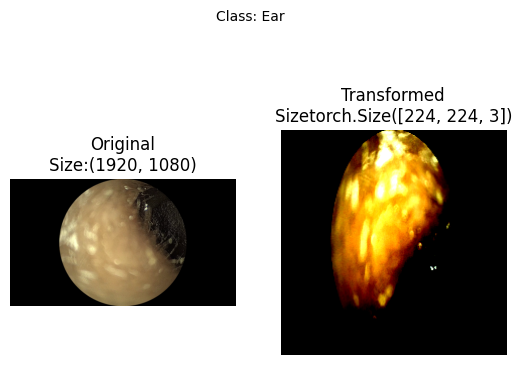

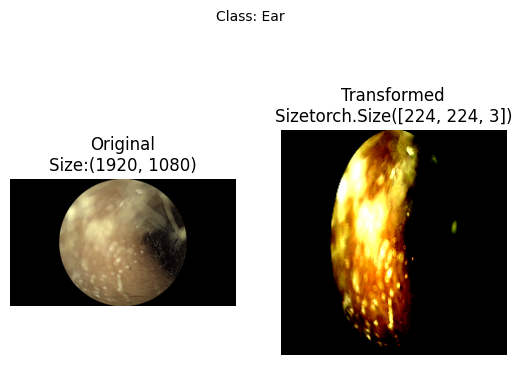

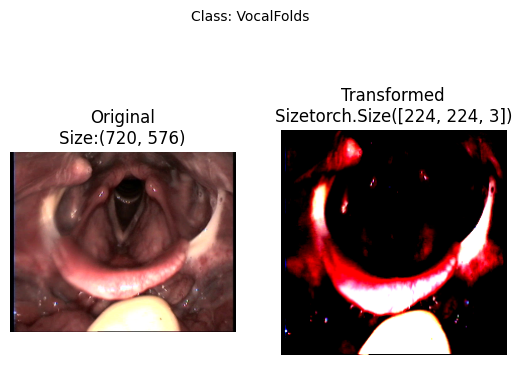

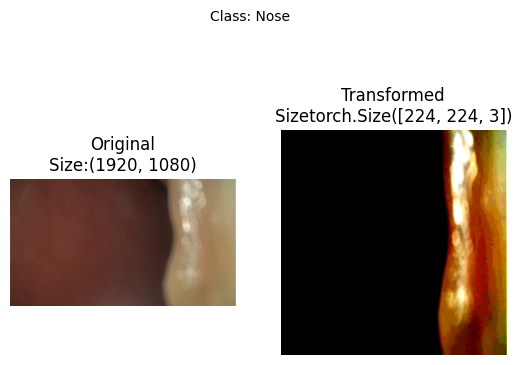

In [ ]:
helper_functions.plot_transformed_images(image_path_list,augmented_transform_1_1,n=4)

In [ ]:
train_dataloader_1_1, test_dataloader_1_1, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                test_dir=test_dir,
                                                train_transform=augmented_transform_1_1,
                                                test_transform=simple_transform,
                                                batch_size=32)

In [ ]:
weights_1_1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1_1 = torchvision.models.efficientnet_b0(weights=weights_1_1).to(device)
for param in model_1_1.features.parameters():
    param.requires_grad = False
# Recreate the classifier layer and seed it to the target device
model_1_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
loss_fn_1_1 = nn.CrossEntropyLoss()
optimizer_1_1 = torch.optim.Adam(params=model_1_1.parameters(),
                             lr=0.001)

Seems like the augmntation was too much, so the model learns well on the train dataset but doesn't learn on the test data. Earlier it has learned on the augmented data with the TinyVGG model. So let's try a VGG transformer

In [ ]:

start_time_1_1 = timer()
results_1_1 = train_step.train(model=model_1_1,
                 train_dataloader=train_dataloader_1_1,
                 test_dataloader=test_dataloader_1_1,
                 optimizer=optimizer_1_1,
                 loss_fn=loss_fn_1_1,
                 epochs=11,
                 device=device)
end_time_1_1 = timer()
print(f"total training time: {end_time_1_1-start_time_1_1}secs")

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6487 | train_acc: 81.40% | test_loss: 0.9443 | test_acc: 63.28%
Epoch: 2 | train_loss: 0.2124 | train_acc: 97.03% | test_loss: 0.8603 | test_acc: 64.45%
Epoch: 3 | train_loss: 0.1436 | train_acc: 97.65% | test_loss: 0.8988 | test_acc: 64.45%
Epoch: 4 | train_loss: 0.1098 | train_acc: 97.66% | test_loss: 0.8599 | test_acc: 64.45%
Epoch: 5 | train_loss: 0.0934 | train_acc: 97.34% | test_loss: 0.8266 | test_acc: 64.45%
Epoch: 6 | train_loss: 0.0918 | train_acc: 98.28% | test_loss: 0.7597 | test_acc: 64.45%
Epoch: 7 | train_loss: 0.0606 | train_acc: 99.53% | test_loss: 0.8070 | test_acc: 64.45%
Epoch: 8 | train_loss: 0.0649 | train_acc: 97.97% | test_loss: 0.8147 | test_acc: 64.45%
Epoch: 9 | train_loss: 0.0664 | train_acc: 98.43% | test_loss: 0.7699 | test_acc: 64.45%
Epoch: 10 | train_loss: 0.0446 | train_acc: 99.22% | test_loss: 0.8309 | test_acc: 64.45%
Epoch: 11 | train_loss: 0.0493 | train_acc: 98.59% | test_loss: 0.9015 | test_acc: 64.45%


TypeError: ignored

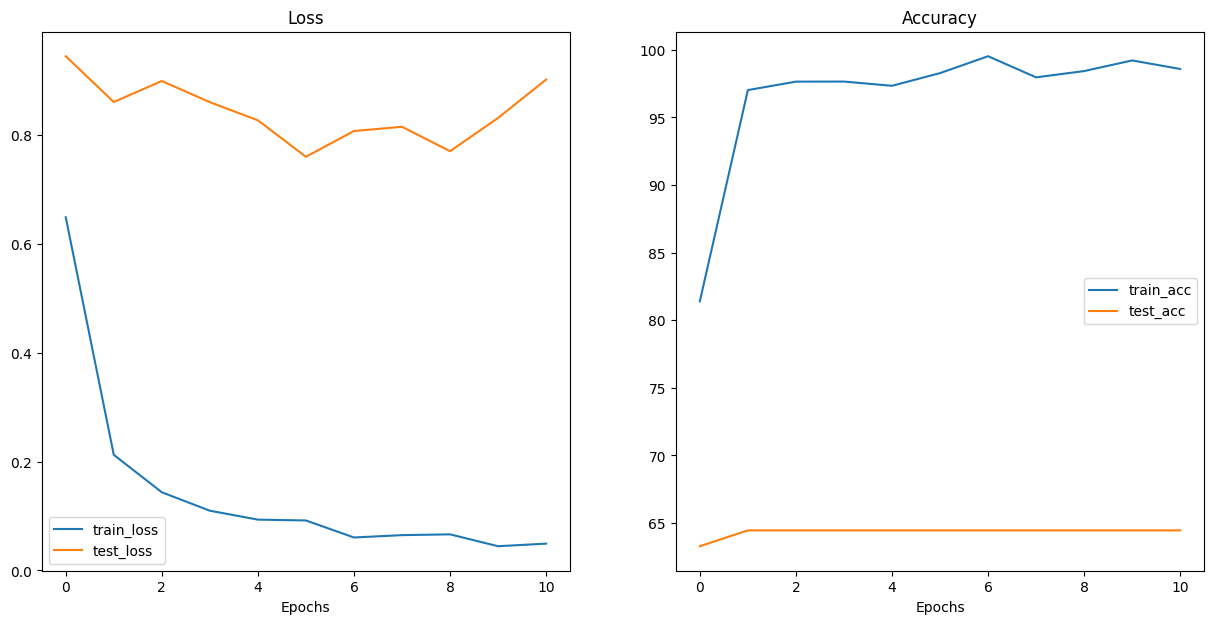

In [ ]:
helper_functions.plot_loss_curves(results_1_1)

## model_1_2: merge the augmnted with not augmented

In [ ]:
augmented_transform_1_2 = transforms.Compose([transforms.TrivialAugmentWide(15),
                                              transforms.Resize((224, 224)), 
                                              transforms.ToTensor(), # this includes scaling the pixel values 0..1
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                  std=[0.229, 0.224, 0.225])
                                          ])
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # for the tinyVGG
    transforms.ToTensor()
])

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=simple_transform)
train_data_2 = datasets.ImageFolder(train_dir, transform=augmented_transform_1_2)
test_data = datasets.ImageFolder(test_dir, transform=simple_transform)
train_data_new = torch.utils.data.ConcatDataset([train_data, train_data_2])
class_names = train_data.classes

train_dataloader_1_2 = DataLoader(
    train_data_new,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
)
test_dataloader_1_2 = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)
len(train_dataloader_1_2.dataset)

1278

In [ ]:
weights_1_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1_2 = torchvision.models.efficientnet_b0(weights=weights_1_2).to(device)
for param in model_1_2.features.parameters():
    param.requires_grad = False
model_1_2.classifier = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True), 
  torch.nn.Linear(in_features=1280, 
                  out_features=len(class_names), # same number of output units as our number of classes
                  bias=True)).to(device)
loss_fn_1_2 = nn.CrossEntropyLoss()
optimizer_1_2 = torch.optim.Adam(model_1_2.parameters(), lr=0.001)

In [ ]:
start_time_1_2 = timer()
results_1_2 = train_step.train(model=model_1_2,
                           train_dataloader=train_dataloader_1_2,
                           test_dataloader=test_dataloader_1_2,
                           optimizer=optimizer_1_2,
                           loss_fn=loss_fn_1_2,
                           epochs=6,
                           device=device)
end_time_1_2 = timer()
print(f"total training time: {end_time_1_2-start_time_1_2:.3f} secconds")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4699 | train_acc: 88.97% | test_loss: 0.4418 | test_acc: 82.42%
Epoch: 2 | train_loss: 0.1391 | train_acc: 97.42% | test_loss: 0.3877 | test_acc: 82.42%
Epoch: 3 | train_loss: 0.0914 | train_acc: 98.52% | test_loss: 0.4228 | test_acc: 81.64%
Epoch: 4 | train_loss: 0.0718 | train_acc: 98.75% | test_loss: 0.4626 | test_acc: 81.25%
Epoch: 5 | train_loss: 0.0592 | train_acc: 98.83% | test_loss: 0.5047 | test_acc: 81.64%
Epoch: 6 | train_loss: 0.0468 | train_acc: 99.37% | test_loss: 0.5590 | test_acc: 80.47%
total training time: 1564.772 secconds


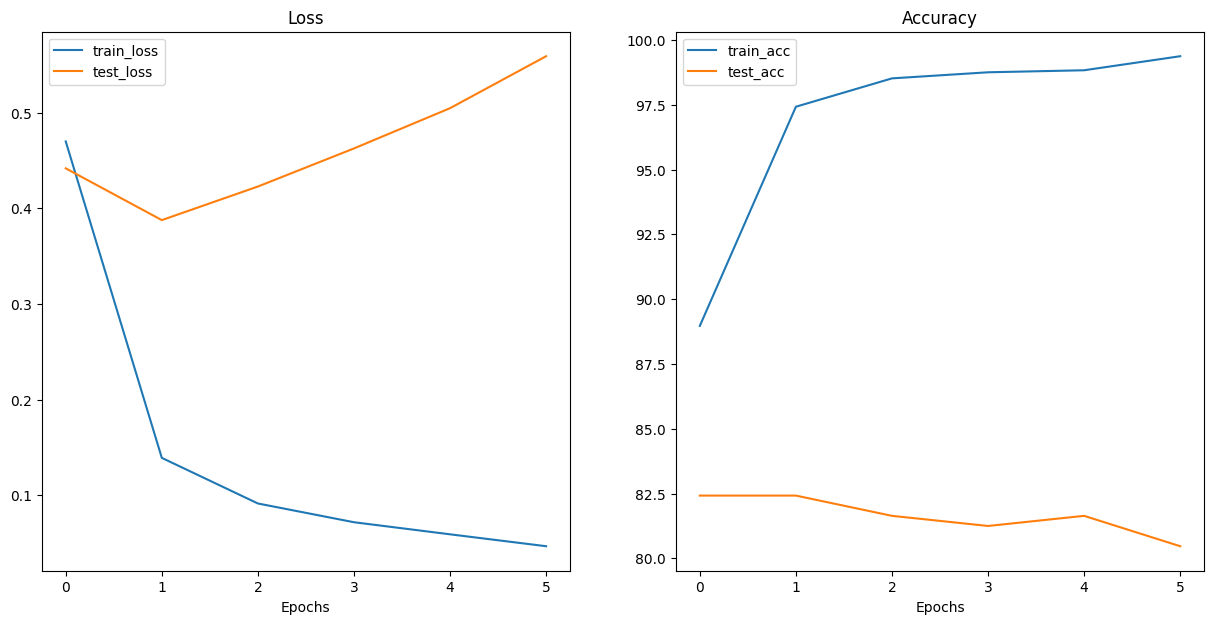

In [ ]:
helper_functions.plot_loss_curves(results_1_2)

# model_2
So, we need to use data augmentation, bcs we don't have enough data. 
Which models work well with data augmentation.
From the experience in the previous notebook, we had good results with the tiny vgg model.
So let's try another vgg model
Models trained with data augmentation usually generalize better but the remaining question is to what extend the Data Transformation can improve the performance of CNN model on image dataset: https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4


# Notes:
* Why not merging the augmented and the simple data together, and shuffle...

In [ ]:
weights_vgg11 = torchvision.models.VGG11_Weights.DEFAULT
model_2 = torchvision.models.vgg11(weights=weights_vgg11).to(device)
summary(model=model_2, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:24<00:00, 21.3MB/s]


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (2)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (3)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (4)                          [32, 128, 112, 112]  [32, 128, 112, 112]  --                   --
│    └─MaxPool2d (5)                     [32, 128, 112, 112]  [32, 128, 56, 56]    --                   --
│    └─Conv2d (6)     

In [ ]:
model_2

In [ ]:
augmented_transform_2 = transforms.Compose([transforms.TrivialAugmentWide(25),
                                              transforms.Resize((224, 224)), 
                                              transforms.ToTensor(), # this includes scaling the pixel values 0..1])
                                          ])
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # for the tinyVGG
    transforms.ToTensor()
])

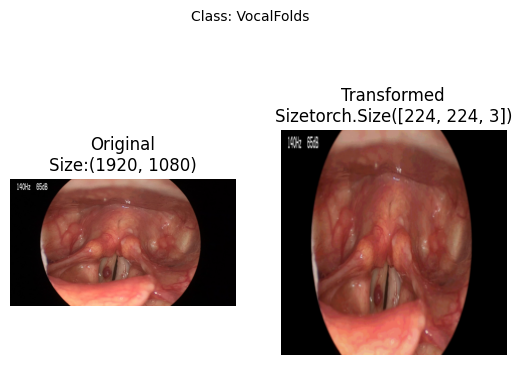

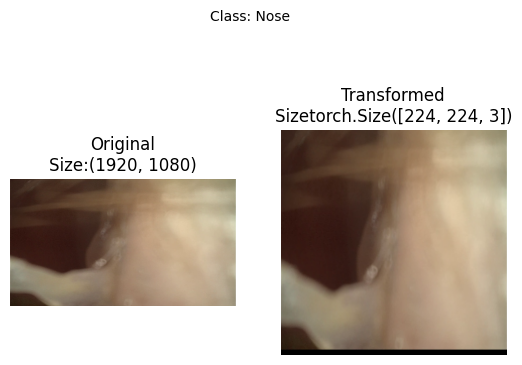

In [ ]:
image_path_list = list(dataset_path.glob("*/*/*.png"))
helper_functions.plot_transformed_images(image_path_list, augmented_transform_2, n=2)

In [ ]:
train_dataloader_2, test_dataloader_2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                test_dir=test_dir,
                                                train_transform=augmented_transform_2,
                                                test_transform=simple_transform,
                                                batch_size=32)

In [ ]:
for param in model_2.features.parameters():
    param.requires_grad = False
# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088, out_features=4096, bias=True), 
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=len(class_names), bias=True)).to(device)
model_2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)

In [ ]:
start_time_2 = timer()
results_2 = train_step.train(model=model_2,
                 train_dataloader=train_dataloader_2,
                 test_dataloader=test_dataloader_2,
                 optimizer=optimizer_2,
                 loss_fn=loss_fn_2,
                 epochs=5,
                 device=device)
end_time_2 = timer()
print(f"total train time: {end_time_2-start_time_2:.3f} secs")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4204 | train_acc: 89.22% | test_loss: 21.7249 | test_acc: 85.55%
Epoch: 2 | train_loss: 0.1105 | train_acc: 98.28% | test_loss: 23.4724 | test_acc: 85.16%
Epoch: 3 | train_loss: 0.3526 | train_acc: 97.33% | test_loss: 0.5067 | test_acc: 95.31%
Epoch: 4 | train_loss: 0.1402 | train_acc: 98.75% | test_loss: 2.1878 | test_acc: 92.97%
Epoch: 5 | train_loss: 0.1525 | train_acc: 98.44% | test_loss: 2.2848 | test_acc: 92.19%
total train time: 1885.462 secs


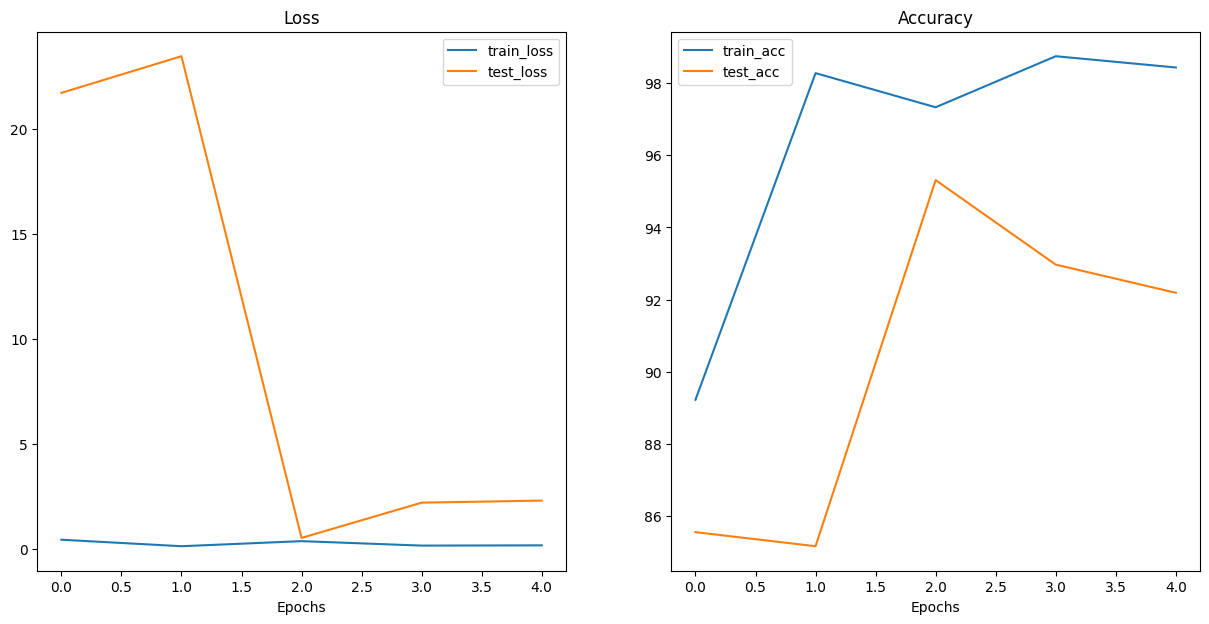

In [30]:
helper_functions.plot_loss_curves(results_2)

## model_2_1: Increasing the data buy duplicating the train data

* merge the augmented with non augmented pics
* get internet photos and make multaple copies from

In [ ]:
weights_vgg11_1 = torchvision.models.VGG11_Weights.DEFAULT
model_2_1 = torchvision.models.vgg11(weights=weights_vgg11_1).to(device)
weights_vgg11_1.transforms

In [ ]:
augmented_transform_2_1 = transforms.Compose([transforms.TrivialAugmentWide(25),
                                              transforms.Resize((224, 224)), 
                                              transforms.ToTensor(), # this includes scaling the pixel values 0..1])
                                          ])
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # for the tinyVGG
    transforms.ToTensor()
])

In [ ]:

train_data = datasets.ImageFolder(train_dir, transform=simple_transform)
train_data_2 = datasets.ImageFolder(train_dir, transform=augmented_transform_2_1)
test_data = datasets.ImageFolder(test_dir, transform=simple_transform)
train_data_new = torch.utils.data.ConcatDataset([train_data, train_data_2])
class_names = train_data.classes

train_dataloader_2_1 = DataLoader(
    train_data_new,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
)
test_dataloader_2_1 = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)
len(train_dataloader_2_1.dataset)

In [ ]:
for param in model_2_1.features.parameters():
    param.requires_grad = False
# Recreate the classifier layer and seed it to the target device
model_2_1.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=25088, out_features=4096, bias=True), 
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=len(class_names), bias=True)).to(device)
model_2_1

In [ ]:
loss_fn_2_1 = nn.CrossEntropyLoss()
optimizer_2_1 = torch.optim.Adam(params=model_2_1.parameters(),
                                 lr=0.001)

In [ ]:
start_time_21 = timer()
results_2_1 = train_step.train(model=model_2_1,
                               train_dataloader=train_dataloader_2_1,
                               test_dataloader=test_dataloader_2_1,
                               optimizer=optimizer_2_1,
                               loss_fn=loss_fn_2_1,
                               epochs=5,
                               device=device)
end_time_21 = timer()
print(f"Total time: {end_time_21-start_time_21:.3f} secs")

In [ ]:
results_2_1

In [31]:
helper_functions.plot_loss_curves(results_2_1)

NameError: ignored

In [ ]:
# 5 epochs
train_preds, train_targets = helper_functions.make_predictions(train_dataloader_2_1,model_2_1,device)
helper_functions.plot_confusion(train_targets, train_preds, class_names)

In [ ]:
# 5 epochs
test_preds, test_targets = helper_functions.make_predictions(test_dataloader_2_1,model_2_1,device)
helper_functions.plot_confusion(test_targets, test_preds, class_names)

In [ ]:
list = os.walk("/content/drive/My Drive/NewExamples/ImagesFromTheInternet")
images = next(list)[2]
index = 1

for image in images[:6]:
  plt.subplot(3,2, index)
  helper_functions.predict_on_custom(model=model_2_1,
                img_path=f"/content/drive/My Drive/NewExamples/ImagesFromTheInternet/{image}",
                class_names=class_names,
                target_size=224,
                device=device)
  index += 1

In [ ]:
# to figure out why some tensors have 4 colour channels, 
# TODO: try it later with the dataloader creation
images_as_tensor = []
for image in images:
  with Image.open(f"/content/drive/My Drive/NewExamples/ImagesFromTheInternet/{image}") as img:

    print(img.mode)
    rgb_image = img.convert('RGB')
    images_as_tensor.append(transforms.ToTensor()(rgb_image)) 
    print(f"{transforms.ToTensor()(rgb_image).shape}, {image}, index:{len(images_as_tensor)-1}")

In [ ]:
# 5 more epochs
start_time_21 = timer()
results_2_1_ = train_step.train(model=model_2_1,
                               train_dataloader=train_dataloader_2_1,
                               test_dataloader=test_dataloader_2_1,
                               optimizer=optimizer_2_1,
                               loss_fn=loss_fn_2_1,
                               epochs=5,
                               device=device)
end_time_21 = timer()
print(f"Total time: {end_time_21-start_time_21:.3f} secs")

In [ ]:
# 10
test_preds, test_targets = helper_functions.make_predictions(test_dataloader_2_1,model_2_1,device)
helper_functions.plot_confusion(test_targets, test_preds, class_names)

In [ ]:
# 10 
train_preds, train_targets = helper_functions.make_predictions(train_dataloader_2_1,model_2_1,device)
helper_functions.plot_confusion(train_targets, train_preds, class_names)